In [17]:
from sklearn import random_projection, cross_validation, datasets, grid_search, linear_model, metrics, manifold, preprocessing
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from collections import  Counter
import numpy as np
import pandas as pd
from sklearn.decomposition import RandomizedPCA
from sklearn import manifold
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn import svm
from sklearn.decomposition import TruncatedSVD, PCA
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [18]:
list_df = [pd.read_csv('dataframe/genres_13.csv'), pd.read_csv('dataframe/genres_20.csv'),
           pd.read_csv('dataframe/genres_30.csv'), pd.read_csv('dataframe/genres_40.csv'), 
           pd.read_csv('dataframe/genres_50.csv')]
for i in range(5):
    list_df[i].loc[:, 'm1':] = preprocessing.normalize(list_df[i].loc[:, 'm1':])
    list_df[i] = list_df[i].sample(frac=1)

In [19]:
def search_abnom(dataframe, label, g, nu):
    svm_ = svm.OneClassSVM(gamma=g, nu=nu)
    svm_.fit(dataframe[dataframe['tag'] == label].loc[:, 'm1':])
    l = svm_.predict(dataframe[dataframe['tag'] == label].loc[:, 'm1':])
    return l

labels = ['hiphop', 'classical', 'jazz', 'rock', 'metal', 'synth', 'pop', 'blues']
for i in range(len(list_df)):
    for label in labels:
        svm_label = search_abnom(list_df[i], label, 2, 0.15).tolist()
        list_df[i][list_df[i]['tag'] == label] = list_df[i][list_df[i]['tag'] == label][np.array(svm_label) == 1]
        list_df[i] = list_df[i].dropna()

In [42]:
rfc = RandomForestClassifier(max_depth=23, n_estimators=1300)

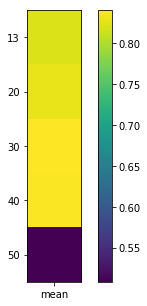

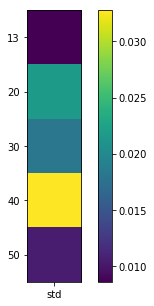

In [21]:
list_rps = []
for i in range(5):
    ridge_scoring2 = cross_validation.cross_val_score(rfc, list_df[i].loc[:, 'm1':], list_df[i]['tag'], 
                                                          scoring='f1_weighted', cv = 5)
    list_rps.append(ridge_scoring2)

m = np.transpose(np.array([list_rps]).mean(axis=2))
s = np.transpose(np.array([list_rps]).std(axis=2))
                 
figure(figsize=(6,5))
plt.imshow(m)
plt.colorbar()
plt.yticks(np.arange(5), ('13', '20', '30', '40', '50'))
plt.xticks([0], ('mean',))
show()

figure(figsize=(6,5))
plt.imshow(s)
plt.colorbar()
plt.yticks(np.arange(5), ('13', '20', '30', '40', '50'))
plt.xticks([0], ('std',))
show()

In [22]:
def synthesis_coef(list_numb, func):
    list_scoring = []
    for i in range(5):
        list_rps = []
        for j in range(4):
            projection = func(n_components = list_numb[i][j])
            data_rp = projection.fit_transform(list_df[i].loc[:, 'm1':])
            ridge_scoring2 = cross_validation.cross_val_score(rfc, data_rp, list_df[i].loc[:, 'tag'], 
                                                              scoring='f1_weighted', cv = 5)
    #         print('Ridge mean:{}, max:{}, min:{}, std:{}'.format(ridge_scoring2.mean(), ridge_scoring2.max(),
    #                                                              ridge_scoring2.min(), ridge_scoring2.std()))
            list_rps.append(ridge_scoring2)
        list_scoring.append(list_rps)
    return list_scoring

def selection_coef(list_numb, list_fi):
    list_scoring = []
    for i in range(5):
        list_rps = []
        for j in range(4):
            data_more_med = list_df[i].loc[:, list_fi[i]>(np.median(list_fi[i])*list_numb[j])]
            ridge_scoring2 = cross_validation.cross_val_score(rfc, data_more_med.loc[:, 'm1':], data_more_med.loc[:, 'tag'], 
                                                              scoring='f1_weighted', cv = 5)
    #         print('Ridge mean:{}, max:{}, min:{}, std:{}'.format(ridge_scoring2.mean(), ridge_scoring2.max(),
    #                                                              ridge_scoring2.min(), ridge_scoring2.std()))
            list_rps.append(ridge_scoring2)
        list_scoring.append(list_rps)
    return list_scoring

def pain_ls(list_scoring):
    figure(figsize=(6,5))
    plt.imshow(np.array(list_scoring).mean(axis=2)) 
    plt.colorbar()
    # plt.plot(range(6), np.array(list_scoring[0]).mean(axis=1))
    # plt.plot(range(6), np.array(list_scoring[0]).max(axis=1) - np.array(list_scoring).min(axis=1))
    plt.yticks(np.arange(5), ('13', '20', '30', '40', '50'))
    plt.xticks(np.arange(4), ('2', '3', '4', '5'))
    show()

    figure(figsize=(6,5))
    plt.imshow(np.array(list_scoring).max(axis=2) - np.array(list_scoring).min(axis=2)) 
    plt.colorbar()
    # plt.plot(range(6), np.array(list_scoring[0]).mean(axis=1))
    # plt.plot(range(6), np.array(list_scoring[0]).max(axis=1) - np.array(list_scoring).min(axis=1))
    plt.yticks(np.arange(5), ('13', '20', '30', '40', '50'))
    plt.xticks(np.arange(4), ('2', '3', '4', '5'))
    show()

In [43]:
fi = []
for df in list_df:
    rfc.fit(df.loc[:, 'm1':], df.loc[:, 'tag'])
    fi.append(rfc.feature_importances_) 

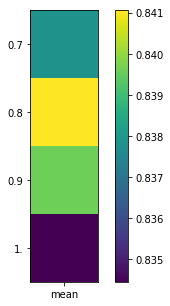

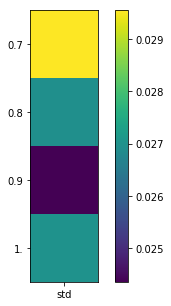

In [50]:
list_numb = [0.7,  0.8,  0.9,  1.]
list_rps = []
for j in range(4):
    data_more_med = list_df[3].loc[:, fi[3]>np.median(fi[3])*list_numb[j]]
    ridge_scoring2 = cross_validation.cross_val_score(rfc, data_more_med.loc[:, 'm1':], data_more_med.loc[:, 'tag'], 
                                                              scoring='f1_weighted', cv = 5)
    print('Ridge mean:{}, max:{}, min:{}, std:{}'.format(ridge_scoring2.mean(), ridge_scoring2.max(),
                                                                 ridge_scoring2.min(), ridge_scoring2.std()))
    print(shape(data_more_med))
    print()
    list_rps.append(ridge_scoring2)

m = np.transpose(np.array([list_rps]).mean(axis=2))
s = np.transpose(np.array([list_rps]).std(axis=2))
    
figure(figsize=(6,5))
plt.imshow(m)
plt.colorbar()
plt.yticks(np.arange(4), ('0.7', '0.8',  '0.9',  '1.'))
plt.xticks([0], ('mean',))
show()

figure(figsize=(6,5))
plt.imshow(s)
plt.colorbar()
plt.yticks(np.arange(4), ('0.7',  '0.8',  '0.9',  '1.'))
plt.xticks([0], ('std',))
show()

In [52]:
from scipy import save
save('boost_param.npy', fi[3]>np.median(fi[3])*0.9)

In [49]:
np.shape(data_more_med)

(1353, 53)